In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
from IPython.display import clear_output
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
import simulate
import two_points

import models as models
from models import MLP, CNN, ResNet

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

with io.capture_output() as captured:
    pub_show()

traj_path = "plots/2 points/comparisons/"

GPU available


In [2]:
## Load settings
setting = "lazy"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[setting]
    .to_numpy()
)
model_type = getattr(models, model_type)
if nonlinearity == "discontinuous":
    nonlinearity = simulate.Discontinuous.apply
elif nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)


threshold = 1e-4
n_epochs_plot = 20000
hidden_layer = 5
L = 10

In [29]:
## Fit effective learning rates
eta_h_opts, eta_y_opts = [], []
Gs = []
for _ in range(30):
    data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

    model = model_type(
        encoding=encoding,
        input_size=1,
        output_size=1,
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
        non_linearity=nonlinearity,
    )

    criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation([data])),
        "hidden": ActivationTracker(
            model, lambda inputs: model(inputs)[1][hidden_layer]
        ),
        "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
    }

    h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

    compiler.training_run([data], [data], n_epochs=n_epochs, batch_size=100)

    if compiler.trackers["loss"].get_entry(-1)[0][0] > threshold:
        continue

    data_hid = compiler.trackers["hidden"].get_trace().copy()
    data_output = compiler.trackers["output"].get_trace().copy()
    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    y_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    y_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    epochs = np.arange(0, len(h_A))
    y_true_A, y_true_B = data[0][1].numpy(), data[1][1].numpy()
    dy2 = np.sum((y_true_B - y_true_A) ** 2)
    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
    y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
    w = np.array(
        [
            y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
            for epoch in epochs
        ]
    )

    # eta_h_opt, eta_y_opt = simulate.optimize_eta(h2, y2, w, dx2, dy2)
    # eta_h_opts.append(eta_h_opt)
    # eta_y_opts.append(eta_y_opt)
    # print(eta_h_opt, eta_y_opt)

    # Compute G
    input_1 = data[0][0]
    input_2 = data[0][1]
    pred_1 = model(input_1)[0]
    pred_2 = model(input_2)[0]
    input_1, input_2, pred_1, pred_2 = [
        a.detach().numpy() for a in (input_1, input_2, pred_1, pred_2)
    ]
    G = np.linalg.norm(pred_2 - pred_1) ** 2 / np.linalg.norm(input_2 - input_1) ** 2
    Gs.append(G)
    print(f"G: {G}")

eta_h, eta_y = np.mean(eta_h_opts), np.mean(eta_y_opts)

G = np.mean(Gs)

print(f"eta_h, eta_y,G = {eta_h}, {eta_y},{G}")

Training: 100%|██████████| 3000/3000 [00:20<00:00, 145.83steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.41978689073464287


Training: 100%|██████████| 3000/3000 [00:18<00:00, 161.24steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.18671680935737903


Training: 100%|██████████| 3000/3000 [00:17<00:00, 167.14steps/s, train_loss=0.00000, val_loss=0.00000]


G:5.3167213246222954e-05


Training: 100%|██████████| 3000/3000 [00:18<00:00, 164.37steps/s, train_loss=0.00002, val_loss=0.00002]


G:0.0012975651227598041


Training: 100%|██████████| 3000/3000 [00:18<00:00, 159.48steps/s, train_loss=0.00001, val_loss=0.00001]


G:0.3257029673265785


Training: 100%|██████████| 3000/3000 [00:18<00:00, 160.71steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.003190396585648839


Training: 100%|██████████| 3000/3000 [00:18<00:00, 162.00steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.0003399456930685021


Training: 100%|██████████| 3000/3000 [00:19<00:00, 150.50steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.0005870511635269362


Training: 100%|██████████| 3000/3000 [00:19<00:00, 156.03steps/s, train_loss=0.00002, val_loss=0.00002]


G:0.033569425090804295


Training: 100%|██████████| 3000/3000 [00:18<00:00, 161.09steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.5897453057267797


Training: 100%|██████████| 3000/3000 [00:18<00:00, 160.72steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.01214868539935079


Training: 100%|██████████| 3000/3000 [00:18<00:00, 162.22steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.009123081093320126


Training: 100%|██████████| 3000/3000 [00:18<00:00, 163.13steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.5714844751329721


Training: 100%|██████████| 3000/3000 [00:18<00:00, 159.49steps/s, train_loss=0.00001, val_loss=0.00001]


G:0.12076186227735727


Training: 100%|██████████| 3000/3000 [00:19<00:00, 153.11steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.0403989671387103


Training: 100%|██████████| 3000/3000 [00:18<00:00, 160.45steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.06650251436136848


Training: 100%|██████████| 3000/3000 [00:19<00:00, 157.56steps/s, train_loss=0.00002, val_loss=0.00002]


G:0.30564557720950564


Training: 100%|██████████| 3000/3000 [00:20<00:00, 148.27steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.0029552033593928254


Training: 100%|██████████| 3000/3000 [00:18<00:00, 162.15steps/s, train_loss=0.00001, val_loss=0.00001]


G:0.012590019884684528


Training: 100%|██████████| 3000/3000 [00:18<00:00, 160.77steps/s, train_loss=0.00000, val_loss=0.00000]


G:2.7895348711437428e-05


Training: 100%|██████████| 3000/3000 [00:18<00:00, 159.70steps/s, train_loss=0.00000, val_loss=0.00000]


G:2.0536887209445718


Training: 100%|██████████| 3000/3000 [00:18<00:00, 159.47steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.0029113650388822177


Training: 100%|██████████| 3000/3000 [00:19<00:00, 155.77steps/s, train_loss=0.00000, val_loss=0.00000]


G:0.2900477108761426
eta_h, eta_y,G = nan, nan,0.21953372182953929


/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
if setting == "default":
    eta_h, eta_y = 0.0020877677068522342, 0.10208116909174215
if setting == "elu":
    eta_h, eta_y = 0.005803672402515137, 0.005655853213481479
if setting == "gain_1.3":
    eta_h, eta_y, G = 0.0018872979697360493, 0.019601273667067383, 5.409e-05
if setting == "skip":
    eta_h, eta_y = 0.01792881864645138, 0.0037541483387444354
if setting == "tanh":
    eta_h, eta_y = 0.005330850767562925, 0.004559356995640654
if setting == "linear":
    eta_h, eta_y = 0.006383913350493798, 0.005209085364099827
if setting == "narrow":
    eta_h, eta_y = 0.009019062223673728, 0.11573112446814811
if setting == "shallow":
    eta_h, eta_y = 0.009311294325305463, 0.015446764974931849
if setting == "relu":
    eta_h, eta_y = 0.0013260572599296402, 0.06614670042709664
if setting == "cnn":
    eta_h, eta_y = 0.1429049664638375, 0.024994515229592434

# eta_h, eta_y = 0.009408065260520659, 0.07242601567405892  # gain_0.9 10 layers

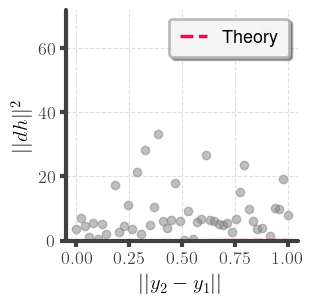

In [5]:
dx2 = 1

h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
dy2s = []

N = 50
m = 1

for dy in np.linspace(0, 1, N):
    dy2 = dy**2
    variables = []
    for _ in range(m):
        ## Generate data
        data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

        ## Instantiate model
        model = model_type(
            encoding=encoding,
            input_size=1,
            output_size=1,
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=nonlinearity,
        )

        criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr / 3)
        compiler = Compiler(model, criterion, optimizer)
        compiler.trackers = {"loss": ScalarTracker(lambda: compiler.validation([data]))}

        h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

        ## Training run
        compiler.training_run(
            [data], [], n_epochs=n_epochs_plot, batch_size=100, conv_thresh=threshold
        )

        if compiler.trackers["loss"].get_entry(-1)[0][0] > threshold:
            break

        h, y, w = two_points.get_h_y_w(data, model, hidden_layer)

        variables.append([h0, y0, w0, h, y, w])

    if len(variables) > 0:
        variables = np.mean(np.array(variables), axis=0)
        for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
            array.append(variables[i])
        dy2s.append(dy2)

        clear_output(wait=True)

        fig = plt.figure(figsize=(3, 3))
        plt.scatter(np.sqrt(dy2s), hs)
        plt.xlabel("$||y_2-y_1||$")
        plt.ylabel("$||dh||^2$")
        plt.ylim(0, 1.1 * max(hs))
        plt.plot(
            np.sqrt(dy2s),
            np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2),
            linestyle="--",
            label="Theory",
        )
        plt.legend()
        pub_show(colors="contrast")

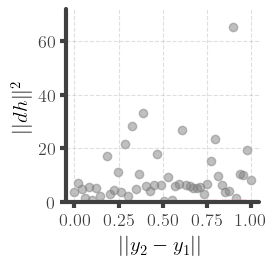

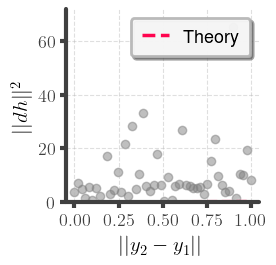

In [7]:
def plot_y():
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.sqrt(dy2s), hs)
    plt.xlabel("$||y_2-y_1||$")
    plt.ylabel("$||dh||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.plot(
        np.sqrt(dy2s),
        np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2),
        linestyle="--",
        label="Theory",
    )
    # plt.plot(np.sqrt(dy2s), G * (1 - eta_h / eta_y) * dx2, linestyle="--", label="Theory")


plot_y()
pub_show(
    colors="contrast",
    save_path=traj_path + "dh_vs_y_" + setting + "_no_legend" + "10_layers" + ".png",
)
plot_y()
plt.legend()
pub_show(
    colors="contrast", save_path=traj_path + "dh_vs_y_" + setting + "10_layers" + ".png"
)

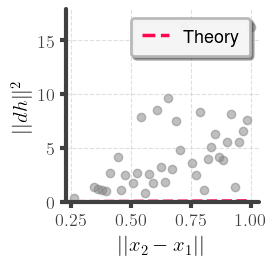

In [8]:
dy2 = 0.5

h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
dx2s = []

N = 50
m = 1

for dx in np.linspace(0.2, 1, N):
    dx2 = dx**2
    variables = []
    for _ in range(m):
        ## Generate data
        data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

        ## Instantiate model
        model = model_type(
            encoding=encoding,
            input_size=1,
            output_size=1,
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=nonlinearity,
        )

        criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr / 3)
        compiler = Compiler(model, criterion, optimizer)
        compiler.trackers = {"loss": ScalarTracker(lambda: compiler.validation([data]))}

        h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

        ## Training run
        compiler.training_run(
            [data], [], n_epochs=n_epochs_plot, batch_size=100, conv_thresh=threshold
        )

        if compiler.trackers["loss"].get_entry(-1)[0][0] > threshold:
            break

        h, y, w = two_points.get_h_y_w(data, model, hidden_layer)

        variables.append([h0, y0, w0, h, y, w])

    if len(variables) > 0:
        variables = np.mean(np.array(variables), axis=0)
        for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
            array.append(variables[i])
        dx2s.append(dx2)

        clear_output(wait=True)

        fig = plt.figure(figsize=(2.5, 2.5))
        plt.scatter(np.sqrt(dx2s), hs)
        plt.xlabel("$||x_2-x_1||$")
        plt.ylabel("$||dh||^2$")
        plt.ylim(0, 1.1 * max(hs))
        plt.plot(
            np.sqrt(dx2s),
            np.sqrt(eta_h / eta_y) * np.sqrt(dx2s) * np.sqrt(dy2),
            linestyle="--",
            label="Theory",
        )
        # plt.plot(
        #     np.sqrt(dx2s),
        #     G * (1 - eta_h / eta_y) * np.array(dx2s),
        #     linestyle="--",
        #     label="Theory",
        # )
        plt.legend()
        pub_show(colors="contrast")

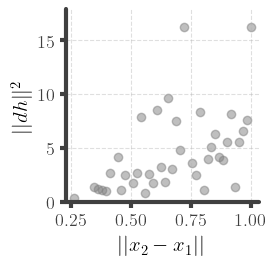

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


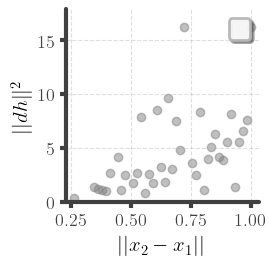

In [19]:
def plot_x():
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.sqrt(dx2s), hs)
    plt.xlabel("$||x_2-x_1||$")
    plt.ylabel("$||dh||^2$")
    plt.ylim(0, 1.1 * max(hs))
    # plt.plot(
    #     np.sqrt(dx2s),
    #     np.sqrt(eta_h / eta_y) * np.sqrt(dx2s) * np.sqrt(dy2),
    #     linestyle="--",
    #     label="Theory",
    # )
    # plt.plot(
    #     np.sqrt(dx2s),
    #     G * (1 - eta_h / eta_y) * np.array(dx2s),
    #     linestyle="--",
    #     label="Theory",
    # )


plot_x()
pub_show(
    colors="contrast",
    save_path=traj_path + "dh_vs_x_" + setting + "_no_legend" + "10_layers" + ".png",
)
plot_x()
plt.legend()
pub_show(
    colors="contrast", save_path=traj_path + "dh_vs_x_" + setting + "10_layers" + ".png"
)